In [1]:
import numpy as np
import torch

from torch import nn
from torch.nn import functional as F
from PIL import Image
from torchvision import transforms, datasets
from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [2]:
dataset = datasets.CIFAR100(root='data/', train=True, download=True)


class MyOwnCifar(torch.utils.data.Dataset):
   
    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]
        if self.transform is not None:
            img = self.transform(img)
        return img, self._base_dataset[idx][1]

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting data/cifar-100-python.tar.gz to data/


In [23]:
trans_actions = transforms.Compose([transforms.Resize(52),
                                    transforms.RandomCrop(32, padding=3), 
                                    transforms.ToTensor()])


def train_valid_split(Xt):
    X_train, X_test = train_test_split(Xt, test_size=0.05, random_state=13)
    return X_train, X_test

train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, transforms.ToTensor())

In [25]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=256,
                          shuffle=True,
                          num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=1)

In [26]:
classes = ['beaver', 'dolphin', 'otter', 'seal', 'whale', 'aquarium fish', 'flatfish', 'ray', 'shark', 'trout',
          'orchids', 'poppies', 'roses', 'sunflowers', 'tulips', 'bottles', 'bowls', 'cans', 'cups', 'plates', 
          'apples', 'mushrooms', 'oranges', 'pears', 'sweet peppers', 'clock', 'computer keyboard', 'lamp', 'telephone', 'television',
          'bed', 'chair', 'couch', 'table', 'wardrobe', 'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach',
          'bear', 'leopard', 'lion', 'tiger', 'wolf', 'bridge', 'castle', 'house', 'road', 'skyscraper',
          'cloud', 'forest', 'mountain', 'plain', 'sea', 'camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo', 
          'fox', 'porcupine', 'possum', 'raccoon', 'skunk', 'crab', 'lobster', 'snail', 'spider', 'worm', 'baby', 'boy', 'girl', 'man', 'woman',
          'crocodile', 'dinosaur', 'lizard', 'snake', 'turtle', 'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel', 
          'maple', 'oak', 'palm', 'pine', 'willow', 'bicycle', 'bus', 'motorcycle', 'pickup truck', 'train', 
          'lawn-mower', 'rocket', 'streetcar', 'tank', 'tractor']

torch.Size([256, 3, 32, 32])
road


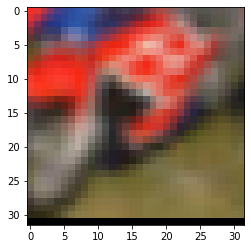

In [27]:
import matplotlib.pyplot as plt


for img, lbl in train_loader:
    print(img.shape)
    print(classes[lbl[0]])
    plt.imshow(img[0].permute(1, 2, 0))
    break

In [28]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [29]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.dp_one = nn.Dropout(0.25)
        self.dp_two = nn.Dropout(0.25)
        
        self.bn_one = torch.nn.BatchNorm2d(3) 
        self.conv_one = torch.nn.Conv2d(3, 40, 3)
        self.bn_two = torch.nn.BatchNorm2d(40) 
        self.conv_two = torch.nn.Conv2d(40, 80, 3)
        self.bn_three = torch.nn.BatchNorm2d(80)
        self.conv_three = torch.nn.Conv2d(80, 160, 3)
        self.bn_four = torch.nn.BatchNorm2d(160)
        self.fc1 = torch.nn.Linear(640, 320)
        self.fc2 = torch.nn.Linear(320, 160)
        self.out = torch.nn.Linear(160, 100)
        
    def forward(self, x):
        x = self.bn_one(x)
        x = self.conv_one(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_two(x)
        x = self.conv_two(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_three(x)
        x = self.conv_three(x)
        x = F.leaky_relu(x, 0.1)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_four(x)
        x = x.view(x.size(0), -1)
        x = self.dp_one(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp_two(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.out(x)
       
net = Net().to(device)
print(net)

Net(
  (dp_one): Dropout(p=0.25, inplace=False)
  (dp_two): Dropout(p=0.25, inplace=False)
  (bn_one): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_one): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1))
  (bn_two): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_two): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1))
  (bn_three): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_three): Conv2d(80, 160, kernel_size=(3, 3), stride=(1, 1))
  (bn_four): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=640, out_features=320, bias=True)
  (fc2): Linear(in_features=320, out_features=160, bias=True)
  (out): Linear(in_features=160, out_features=100, bias=True)
)


In [30]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [33]:
num_epochs = 15
net.train()

for epoch in range(num_epochs):  
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()
        
        # выводим статистику о процессе обучения
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            net.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(valid_loader):
            
                test_outputs = net(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()
            
            print(f'Test acc: {test_running_right / test_running_total:.3f}')
        
        net.train()
        
print('Training is finished!')

Epoch [1/15]. Step [1/186]. Loss: 0.014. Acc: 0.141. Test acc: 0.100
Epoch [2/15]. Step [1/186]. Loss: 0.014. Acc: 0.176. Test acc: 0.115
Epoch [3/15]. Step [1/186]. Loss: 0.015. Acc: 0.117. Test acc: 0.116
Epoch [4/15]. Step [1/186]. Loss: 0.014. Acc: 0.168. Test acc: 0.129
Epoch [5/15]. Step [1/186]. Loss: 0.014. Acc: 0.172. Test acc: 0.113
Epoch [6/15]. Step [1/186]. Loss: 0.013. Acc: 0.168. Test acc: 0.137
Epoch [7/15]. Step [1/186]. Loss: 0.014. Acc: 0.180. Test acc: 0.118
Epoch [8/15]. Step [1/186]. Loss: 0.014. Acc: 0.180. Test acc: 0.160
Epoch [9/15]. Step [1/186]. Loss: 0.014. Acc: 0.156. Test acc: 0.161
Epoch [10/15]. Step [1/186]. Loss: 0.014. Acc: 0.164. Test acc: 0.141
Epoch [11/15]. Step [1/186]. Loss: 0.013. Acc: 0.238. Test acc: 0.145
Epoch [12/15]. Step [1/186]. Loss: 0.013. Acc: 0.180. Test acc: 0.156
Epoch [13/15]. Step [1/186]. Loss: 0.013. Acc: 0.227. Test acc: 0.180
Epoch [14/15]. Step [1/186]. Loss: 0.013. Acc: 0.215. Test acc: 0.149
Epoch [15/15]. Step [1/186]. 